# Init

In [2]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")


Project path set to: c:\Github\new-peak-project\src


In [3]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [4]:
new_path = config["NEW_DATA_PATH"]
print(f'New data path set to: {new_path}')

New data path set to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project


# Config

In [5]:
from models.utils.config_manager import initialise_config

initialise_config(folder_name="dose-range-analysis", verbose=1)


Folder I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\dose-range-analysis already exists. No changes made.


In [6]:
# or load existing config
from models.utils.config_manager import load_configs, print_config

loaded_config = load_configs(folder_name="dose-range-analysis", config_suffix="v1")
print_config(loaded_config)

notebook: 
  version: v1
  name: dose-range-analysis
  compatible_notebooks: ['dose-range-analysis']
  desc: First dose range analysis based on num of cascades  

exp: 
  spec: 
    n_layers: 2
    n_cascades: 10
    n_regs: 0
    gen_seed: 42
    drug: 
      name: D
      start: 500
      dose: 500
      regulations: []
      target_all: True
  parameter_generation: 
    ic_range: [200, 1000]
    param_range: [0.5, 1.5]
    param_mul_range: [0.99, 1.01]
  simulation: 
    start: 0
    stop: 1000
    step: 100
  dose_range: 
    n_cascades_perturb: 
      start: 1
      stop: 10
      step: 1
    n_reps: 10
    dr_seed: 42


# Run

In [48]:
from models.Specs.ModelSpec3 import ModelSpec3
from models.Specs.Drug import Drug

def generate_model_spec(spec_config, seed=None):
    """
    Generate a model specification with drug configuration.

    Args:
        spec_config (dict): The spec configuration containing:
            - n_layers: number of intermediate layers
            - n_cascades: number of cascades
            - n_regs: number of regulations
            - drug: drug configuration dict
            - gen_seed: generation seed (optional, can be overridden)
        seed (int, optional): Override seed for generation

    Returns:
        ModelSpec3: The complete model specification
    """

    # Extract parameters from spec_config
    n_layers = spec_config['n_layers']
    n_cascades = spec_config['n_cascades']
    n_regs = spec_config['n_regs']
    drug_config = spec_config['drug']
    seed = seed or spec_config.get('gen_seed')

    # Create ModelSpec3
    model_spec = ModelSpec3(num_intermediate_layers=n_layers)

    # Configure Drug
    drug_name = drug_config['name']
    drug_start = drug_config['start']
    drug_dose = drug_config['dose']
    drug_regulations = drug_config['regulations']
    drug_target_all = drug_config.get('target_all', False)

    drug = Drug(name=drug_name, start_time=drug_start, default_value=drug_dose)

    if drug_target_all:
        for n in range(n_cascades):
            target = f'R{n+1}'  # Assuming receptors are named R1, R2, ..., Rn
            drug.add_regulation(target, 'down')  # Assuming the type is 'down' for all
    else:
        for regs in drug_regulations:
            target, reg_type = regs[0], regs[1]
            drug.add_regulation(target, reg_type)

    # Generate specifications and add drug
    model_spec.generate_specifications(n_cascades, n_regs, seed)
    model_spec.add_drug(drug)

    return model_spec

def generate_network(builder_config, model_spec, seed=None):
    """
    Generate a network builder from the model specification.

    Args:
        builder_config (dict): The builder configuration containing:
            - ic_range: initial condition range
            - param_range: parameter range
            - param_mul_range: parameter multiplier range
        model_spec (ModelSpec3): The model specification
        seed (int, optional): Override seed for generation

    Returns:
        Builder: The network builder
    """
    param_gen_config = builder_config
    specie_range = param_gen_config['ic_range']
    param_range = param_gen_config['param_range']
    param_mul_range = param_gen_config['param_mul_range']

    builder = model_spec.generate_network('test', specie_range, param_range, param_mul_range, seed)
    return builder


In [63]:
import numpy as np

def calculate_spread_metrics(target_df, target_column="Oa"):
    """
    Calculate various spread/variability metrics for target data. Returns are relative to the mean.

    Args:
        target_df (pd.DataFrame): DataFrame containing target values.
        target_column (str): Column name to analyze (default 'Oa').
        
    Returns:
        dict: Dictionary containing relative spread metrics:
            - rel_range: (max - min) / mean
            - rel_var: variance / mean
            - rsd: standard deviation / mean
            - rel_iqr: (75th percentile - 25th percentile) / mean
    """
    if target_column not in target_df.columns:
        raise ValueError(f"Column '{target_column}' not found in DataFrame.")

    data = target_df[target_column].dropna()  # Drop missing values

    metrics = {
        "rel_range": data.max() - data.min(),
        "rel_var": data.var(),
        "rsd": data.std(),
        "rel_iqr": np.percentile(data, 75) - np.percentile(data, 25),
    }
    
    # Normalise metrics by dividing by the mean of the data
    mean_val = data.mean()
    if mean_val != 0:
        metrics = {k: v / mean_val for k, v in metrics.items()}


    return metrics


In [ ]:
import logging
from models.SyntheticGen import generate_feature_data_v3
from models.SyntheticGen import generate_target_data
from models.Solver.RoadrunnerSolver import RoadrunnerSolver
from tqdm import tqdm
logging.basicConfig(level=logging.NOTSET)

spec_config = loaded_config['exp']['spec']
param_gen_config = loaded_config['exp']['parameter_generation']
dose_range_config = loaded_config['exp']['dose_range']
sim_config = loaded_config['exp']['simulation']
sim_start, sim_stop, sim_step = sim_config['start'], sim_config['stop'], sim_config['step']

n_cascades_perturb = dose_range_config['n_cascades_perturb']
start, stop, step = n_cascades_perturb['start'], n_cascades_perturb['stop'], n_cascades_perturb['step']
n_reps = dose_range_config['n_reps']
dr_seed = dose_range_config['dr_seed']
rng = np.random.default_rng(dr_seed)
seeds = rng.integers(0, 1e6, size=n_reps)

n_cascades_metrics = []
for n_cascades in tqdm(range(start, stop + 1, step), desc="Cascades"):
    for rep in range(n_reps):
        spec_config['n_cascades'] = n_cascades
        spec_config['gen_seed'] = int(seeds[rep])
        model_spec = generate_model_spec(spec_config, seed=42)
        logging.info(f"Generated model with {n_cascades} cascades.")
        builder = generate_network(param_gen_config, model_spec, seed=42)
        logging.info(f"Generated network builder for model with {n_cascades} cascades.")

        initial_values = builder.get_state_variables()
        # exclude all activated species from initial_values
        initial_values = {k: v for k, v in initial_values.items() if not k.endswith("a")}
        # exclude 'O' and 'Oa' from perturbation
        initial_values = {k: v for k, v in initial_values.items() if k not in ["O", "Oa"]}

        feature_data = generate_feature_data_v3(
            model_spec, initial_values, "lhs", {"min": 200, "max": 1000}, 500, spec_config['gen_seed']
        )
        solver = RoadrunnerSolver()
        solver.compile(builder.get_sbml_model())
        sim_params = {"start": sim_start, "end": sim_stop, "points": sim_step}

        target_data, timecourse_data = generate_target_data(
            model_spec, solver, feature_data, sim_params, outcome_var="Oa", verbose=True
        )
        
        # calculate the mean and std of target_data
        metrics = calculate_spread_metrics(target_data, target_column="Oa")
        logging.info(f"Spread metrics for model with {n_cascades} cascades, rep {rep}: {metrics}")
        n_cascades_metrics.append({"n_cascades": n_cascades, "metrics": metrics, "rep_seed": int(seeds[rep])})
    

Cascades:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:Generated model with 1 cascades.
INFO:models.Specs.ModelSpec3:Generated model test with 8 reactions.
INFO:models.Specs.ModelSpec3:Model States: 8
INFO:models.Specs.ModelSpec3:Model Parameters: 20
INFO:models.Specs.ModelSpec3:Model Reactions: 8
INFO:root:Generated network builder for model with 1 cascades.
Simulating perturbations: 100%|██████████| 500/500 [00:00<00:00, 504.03it/s]
INFO:root:Spread metrics for model with 1 cascades, rep 0: {'rel_range': np.float64(0.4827042835798947), 'rel_var': np.float64(0.1394136915910343), 'rsd': np.float64(0.10004774284952317), 'rel_iqr': np.float64(0.1488884931462032)}
INFO:root:Generated model with 1 cascades.
INFO:models.Specs.ModelSpec3:Generated model test with 8 reactions.
INFO:models.Specs.ModelSpec3:Model States: 8
INFO:models.Specs.ModelSpec3:Model Parameters: 20
INFO:models.Specs.ModelSpec3:Model Reactions: 8
INFO:root:Generated network builder for model with 1 cascades.
Simulating 

In [65]:
import pandas as pd
from models.utils.config_manager import save_data

# Assemble the final output into a DataFrame
# Each entry in n_cascades_metrics is a dict: {"n_cascades": ..., "metrics": ..., "rep_seed": ...}
final_df = pd.DataFrame([
    {
        "n_cascades": entry["n_cascades"],
        "rep_seed": entry["rep_seed"],
        **entry["metrics"]
    }
    for entry in n_cascades_metrics
])

final_df.head()

save_data(notebook_config=loaded_config['notebook'], data=final_df, data_name="dose_range_metrics")

In [7]:
import pandas as pd
from models.utils.config_manager import load_data

final_df = load_data(loaded_config['notebook'], "dose_range_metrics")

Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\dose-range-analysis\figures\v1_simulation_plot_rel_range.png


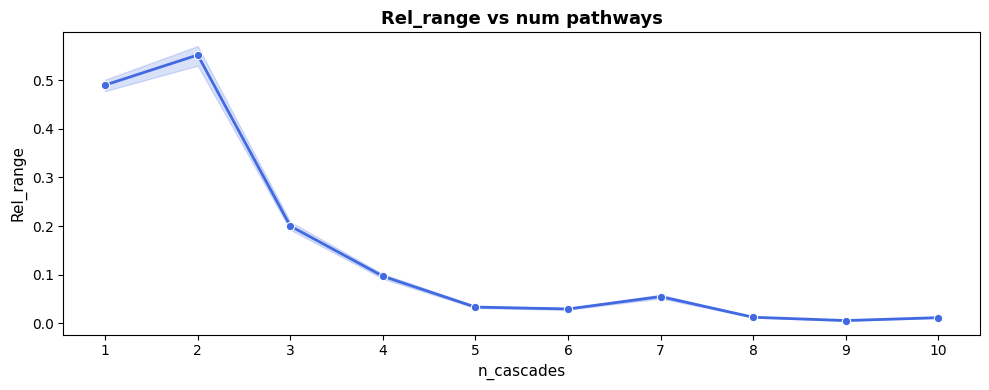

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from models.utils.config_manager import save_figure
# Prompt user to select a metric to plot

def plot_metric(selected_metric):
    plt.figure(figsize=(10, 4))
    sns.boxplot(
        data=final_df,
        x="n_cascades",
        y=selected_metric,
        color="skyblue",
        fliersize=2,
        linewidth=1
    )
    plt.title(f"{selected_metric.capitalize()} vs num pathways", fontsize=13, fontweight="bold")
    plt.xlabel("n_cascades", fontsize=11)
    plt.ylabel(selected_metric.capitalize(), fontsize=11)
    plt.tick_params(axis='both', labelsize=10)
    plt.tight_layout()
    
def plot_metric_line(selected_metric):
    plt.figure(figsize=(10, 4))
    ax = sns.lineplot(
        data=final_df,
        x="n_cascades",
        y=selected_metric,
        marker="o",
        linewidth=2,
        color="royalblue"
    )
    plt.title(f"{selected_metric.capitalize()} vs num pathways", fontsize=13, fontweight="bold")
    plt.xlabel("n_cascades", fontsize=11)
    plt.ylabel(selected_metric.capitalize(), fontsize=11)
    plt.tick_params(axis='both', labelsize=10)
    # Make x-axis ticks discrete
    ax.set_xticks(sorted(final_df["n_cascades"].unique()))
    plt.tight_layout()
    
    
plot_metric_line("rel_range")
save_figure(loaded_config['notebook'], plt.gcf(), "simulation_plot_rel_range", "png", verbose=1, dpi=300)
plt.show()


Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\dose-range-analysis\figures\v1_simulation_plot_rel_var.png
Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\dose-range-analysis\figures\v1_simulation_plot_rsd.png
Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\dose-range-analysis\figures\v1_simulation_plot_rel_iqr.png


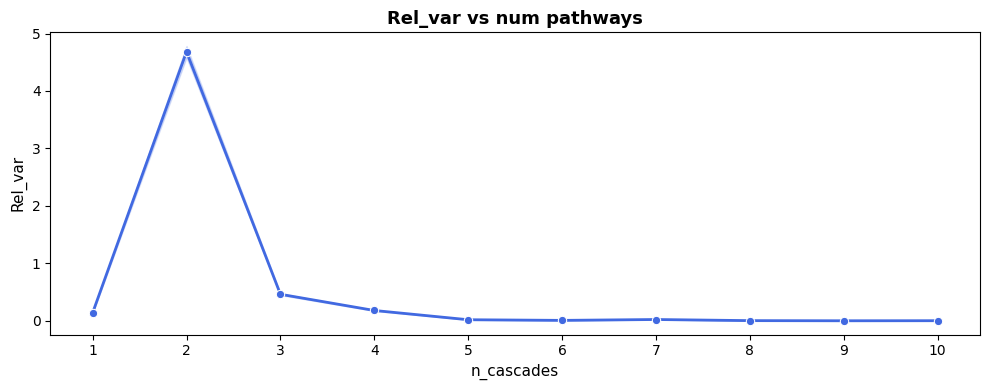

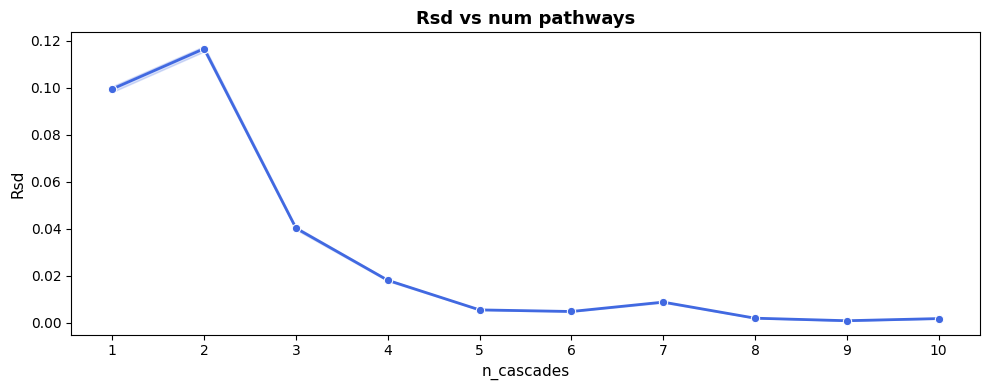

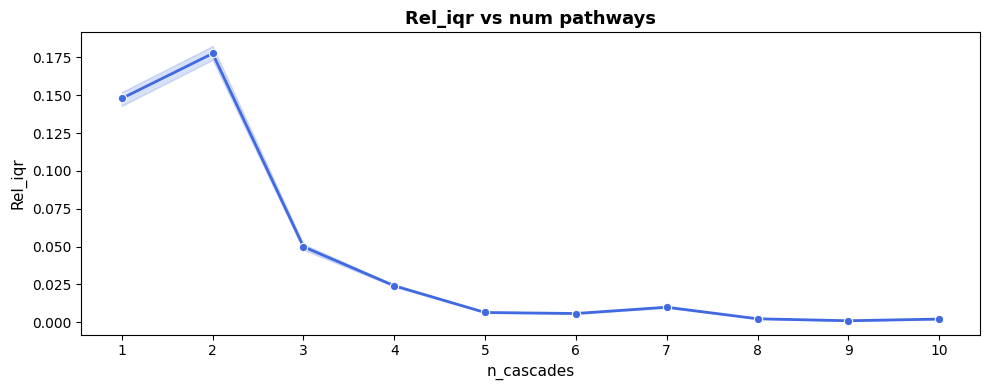

In [9]:
# Plot all other metrics in metrics_to_plot except 'rel_range'
for metric in ["rel_var", "rsd", "rel_iqr"]:
    plot_metric_line(metric)
    save_figure(loaded_config['notebook'], plt.gcf(), f"simulation_plot_{metric}", "png", verbose=1, dpi=300)